In [2]:
import pandas as pd
from scipy.stats import shapiro
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import norm
from tqdm.auto import tqdm
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('/home/jupyter-a.solovev-15/project_statist_1/hw_bootstrap.csv', sep=';')
df.head(5)

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


Приведем к нужным типам данные. Посмотрим, что представляют из себя данные. Построим графики.

In [4]:
df.isna().sum()

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [5]:
df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [6]:
df.value = df.value.apply(lambda x: x.replace(',', '.'))

In [7]:
df = df.astype({'value': 'float128'})

In [8]:
df.value

0        10.380495
1         9.546867
2        11.088215
3        10.147274
4         9.789808
          ...     
995    1000.000000
996    1200.000000
997    1500.000000
998    2000.000000
999    3000.000000
Name: value, Length: 1000, dtype: float128

In [9]:
df.dtypes

Unnamed: 0              int64
value                float128
experimentVariant      object
dtype: object

In [10]:
df.value.value_counts()

10.484967      2
10.136455      2
11.132226      2
10.320132      2
11.012266      2
              ..
11.169078      1
10.973929      1
11.499566      1
10.261074      1
1000.000000    1
Name: value, Length: 505, dtype: int64

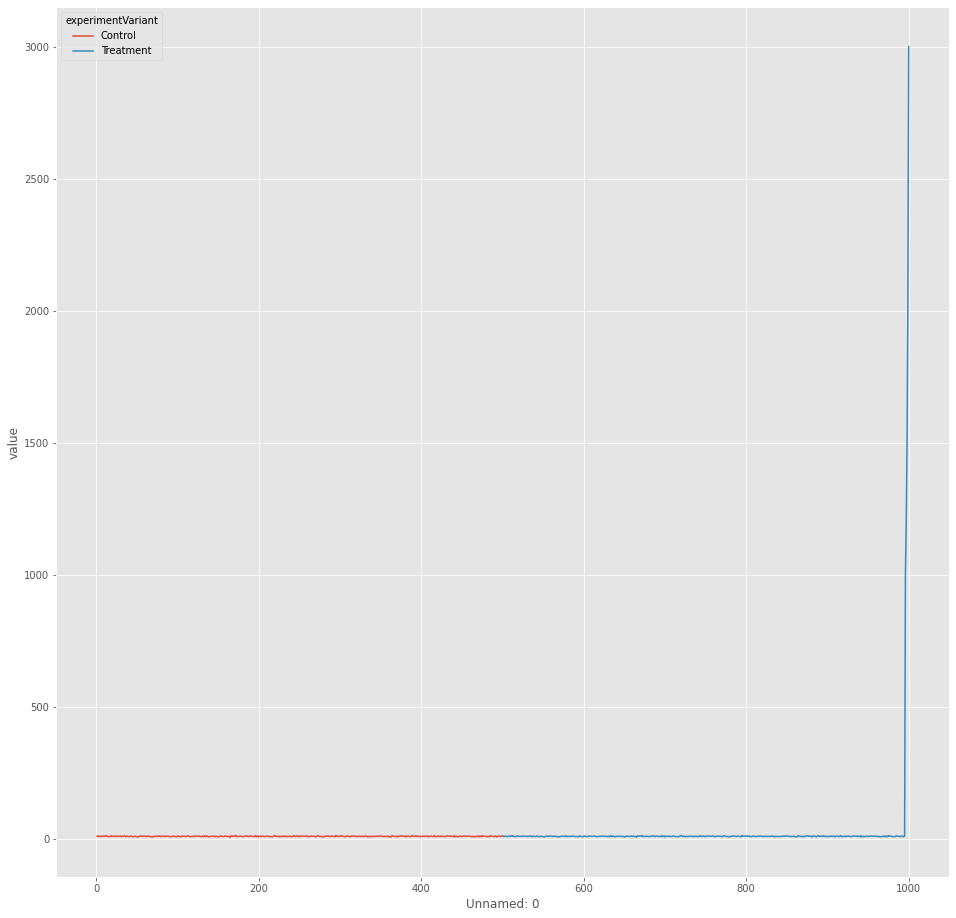

In [11]:
plt.figure(figsize=(16,16))
sns.lineplot(x = 'Unnamed: 0', y = 'value', hue = 'experimentVariant', data = df)

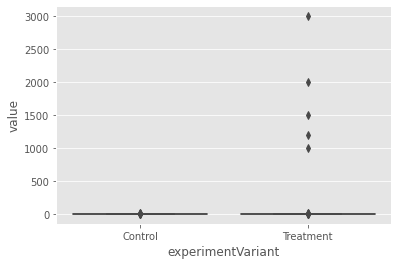

In [50]:
sns.boxplot(x=df["experimentVariant"], y=df["value"])

In [30]:
df[df.experimentVariant == 'Control'].value.describe()

count    500.000000
mean      10.026867
std        0.979377
min        6.436541
25%        9.411024
50%       10.018465
75%       10.664879
max       13.130346
Name: value, dtype: float64

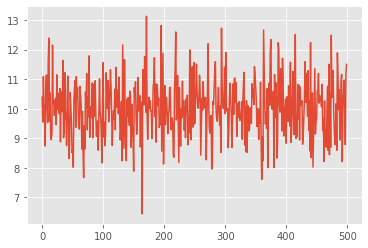

In [31]:
df[df.experimentVariant == 'Control'].value.plot()

In [32]:
df[df.experimentVariant == 'Treatment'].value.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

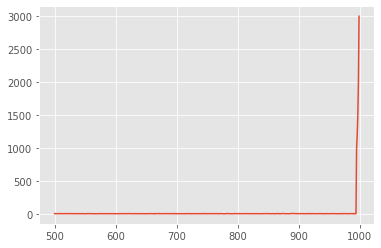

In [33]:
df[df.experimentVariant == 'Treatment'].value.plot()


In [34]:
stat, p = shapiro(df[df.experimentVariant == 'Treatment'].value)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.070, p=0.000


In [35]:
stat, p = shapiro(df[df.experimentVariant == 'Control'].value)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.996, p=0.224


Проведя тест Шапира на нармальность видно, что данные из тестовой группы распределены ненормально. У нас большой размер выборки, поэтому имеем право воспользоваться т тестом.

Но также у нас присутствуют выбросы. Посмотрим на данные, убрав выбросы, обнаруженные выше.

In [36]:
dff = df.query('value < 1000')

experimentVariant
Control      AxesSubplot(0.125,0.125;0.775x0.755)
Treatment    AxesSubplot(0.125,0.125;0.775x0.755)
Name: value, dtype: object

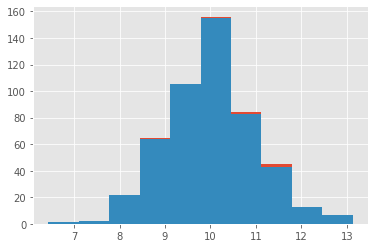

In [37]:
dff.groupby('experimentVariant').value.hist()

In [38]:
stat, p = shapiro(dff.value)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.995, p=0.005


In [39]:
stat, p = shapiro(dff[dff.experimentVariant == 'Treatment'].value)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.996, p=0.172


In [40]:
stat, p = shapiro(dff[dff.experimentVariant == 'Control'].value)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.996, p=0.224


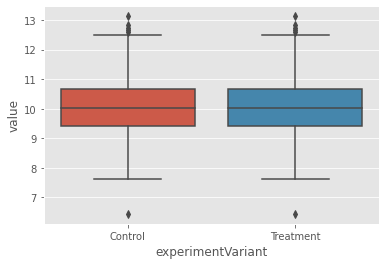

In [51]:
sns.boxplot(x=dff["experimentVariant"], y=dff["value"])

В распределении Treatment есть очевидные выбросы. Так как нет информации о том, что это за данные, поэтому избавиться от них мы не можем. Из-за этого мы должны воспользоваться непараметрическим U тестом

In [41]:
stats.mannwhitneyu(x = df[df.experimentVariant == 'Control'].value, y = df[df.experimentVariant == 'Treatment'].value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

p-value получили достаточно большим, поэтому нет оснований отвергнуть нулевую гипотезу: выборки различаются незначимо - разница в выборках случайна.

In [42]:
x = df[df.experimentVariant == 'Control'].value
y = df[df.experimentVariant == 'Treatment'].value

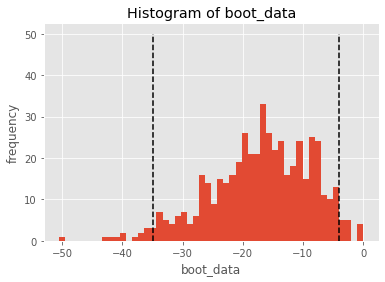

In [43]:
booted_data_mean = get_bootstrap_mean(x, y, boot_it = 500)

In [44]:
booted_data_mean["p_value"]

0.040806174091944564

In [45]:
booted_data_mean["ci"]

,0
0.025,-34.92803
0.975,-3.95668


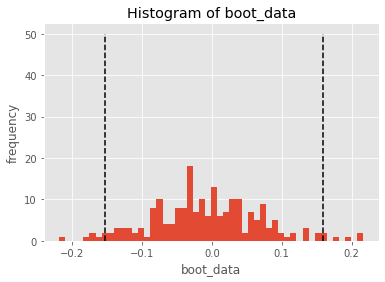

In [46]:
booted_data_median = get_bootstrap_median(x, y, boot_it = 200)

In [47]:
booted_data_median["p_value"]

0.9331758690812744

In [48]:
booted_data_median["ci"]

,0
0.025,-0.152395
0.975,0.159044


U критерий показал, что выборки не различаются pvalue=0.85. Бутстрап для средних показал, что выборки различаются p-value = 0.03, а для медиан, что выборки не отличаются  p-value = 0.93. 
Бутстрап для медиан и u-тест показал статистически одинаковый результат, можно сказать, что в данном случае они эквивалентны ( я немного менял количество бутстрэп-подвыборок, и p-value был в интервале 0,8-0,95)
Бутстрап для средних в данном тесте показал p-value = 0.03, что является на грани отклонения нулевой гипотезы, в зависимости от уровня значимости. Если бы мы не проверяли другими тестами, а также не смотрели на данные, то могли бы допустить ошибку 1 рода

In [27]:
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 500, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}


In [28]:
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 500, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}
